**Deep Learnig course - Semester Project**

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases were grouped into 2 categories according the presence of tumor or not. Initially, the dataset comprised three distinct categories. For the purposes of this study, these categories were consolidated into two broader groups. This adjustment was made to enhance the interpretability of the results and to ensure a more robust analysis by reducing potential class imbalance and increasing the sample size within each group.


**1st part of analysis**
At first, the data set was slit into train and test groups and then a Convulation Neural Network was built. The CNN is comprised of 4 layers and then trained with different epochs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from PIL import Image
import os
from tensorflow.keras import layers, Sequential
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import sklearn.metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator


 Data Loading & Exploratory Data Analysis

In [2]:
dataset = r'/home/konnie/lungdb'
class_folders = ['Tumor', 'Normal']
target_size = (224, 224) 
valid_extensions = ('.jpg', '.jpeg', '.png')

images = []
labels = []

for class_idx, folder_name in enumerate(class_folders):
    class_path = os.path.join(dataset, folder_name)
    
   
    class_images = [
        os.path.join(class_path, fname)
        for fname in os.listdir(class_path)
        if fname.lower().endswith(valid_extensions)
    ]
  
    for img_path in class_images:
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img_resized = img.resize(target_size)
                images.append(np.array(img_resized))
                labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")


images_array = np.array(images)
labels_array = np.array(labels)

print(f"Images array shape: {images_array.shape}")  
print(f"Labels array shape: {labels_array.shape}") 



Images array shape: (1097, 224, 224, 3)
Labels array shape: (1097,)


Visualize the two Classes

Found 1097 files belonging to 2 classes.
Class names: ['Normal', 'Tumor']


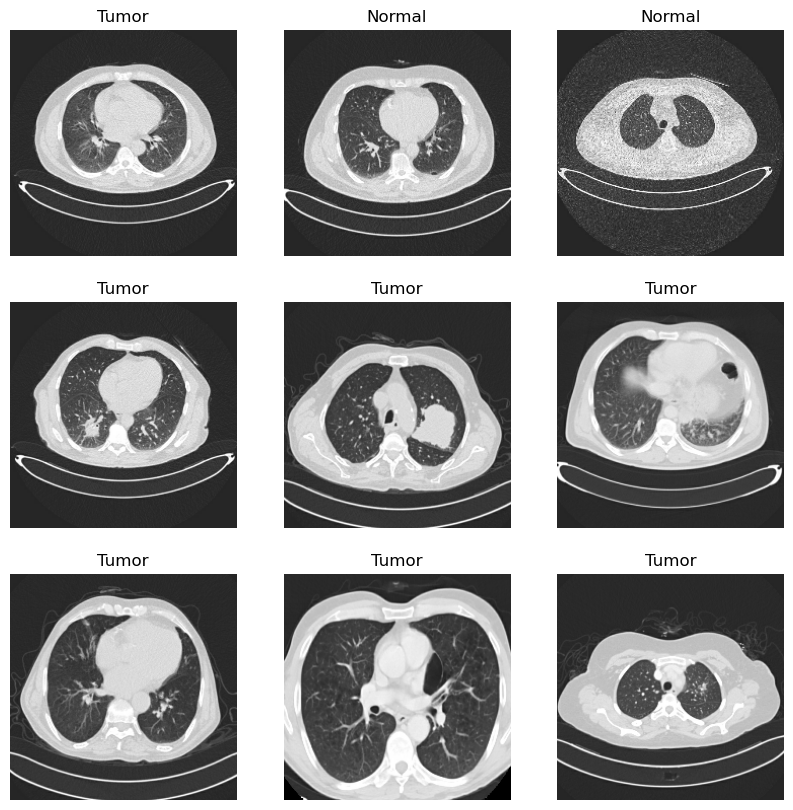

In [27]:
class_names = ['Normal case', 'Tumor case']
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

img_height, img_width = 224, 224
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    labels='inferred',
    label_mode='int', 
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42
)

class_names = train_ds.class_names
print("Class names:", class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Split Dataset into Train and Test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    images_array, labels_array, test_size=0.2, random_state=42)

print("The data type of the images is:", x_train.dtype)
print("The shape of the train set:", x_train.shape)
print("The shape of the test set:", x_test.shape)
print("Number of training observations:", x_train.shape[0])
print("Number of testing observations:", x_test.shape[0])
print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

The data type of the images is: uint8
The shape of the train set: (877, 224, 224, 3)
The shape of the test set: (220, 224, 224, 3)
Number of training observations: 877
Number of testing observations: 220
Train label distribution: Counter({0: 543, 1: 334})
Test label distribution: Counter({0: 138, 1: 82})


Data Preprocessing - Normalization

In [5]:
print(f"Value interval of the train set before the min-max normalization:[{x_train.min()},{x_train.max()}]")
print(f"Value interval of the test set before the min-max normalization:[{x_test.min()},{x_test.max()}]")
# scale the pixels to the [0,1] range
x_train = x_train / 255.0
x_test = x_test / 255.0
print(f"Value interval of the train set after the min-max normalization:[{x_train.min()},{x_train.max()}]")
print(f"Value interval of the test set after the min-max normalization:[{x_test.min()},{x_test.max()}]")

Value interval of the train set before the min-max normalization:[0,255]
Value interval of the test set before the min-max normalization:[0,255]
Value interval of the train set after the min-max normalization:[0.0,1.0]
Value interval of the test set after the min-max normalization:[0.0,1.0]


CNN Overview

In [6]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),         
                    
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(2, activation="softmax")  # For 2 classes: Normal and Tumor
])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

Data Augmentation using ImageDataGenerator

In [7]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,   
    zoom_range=0.1,         
    fill_mode='nearest',    
    validation_split=0.2    
)

Compile the model without augmentation

In [8]:
cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Train and Validation Generator

In [28]:
# Generate training and validation flows
train_generator = data_augmentation.flow(
    x_train, y_train,
    batch_size=64,
    subset='training'
)

validation_generator = data_augmentation.flow(
    x_train, y_train, 
    batch_size=64,
    subset='validation',
    shuffle=False  # Don't shuffle validation data
)

Fitting the model

In [29]:
history_1 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 64,  # 80% of data is used for training with validation_split=0.2
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 64,  # 20% of data is used for validation
)

Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 0.3145 - accuracy: 0.8480 - val_loss: 0.2389 - val_accuracy: 0.9375
Epoch 2/10
10/10 [==============================] - 21s 2s/step - loss: 0.2228 - accuracy: 0.9169 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.2473 - accuracy: 0.9044 - val_loss: 0.2185 - val_accuracy: 0.9219
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.2362 - accuracy: 0.9094 - val_loss: 0.1674 - val_accuracy: 0.9375
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.2172 - accuracy: 0.9091 - val_loss: 0.1306 - val_accuracy: 0.9531
Epoch 6/10
10/10 [==============================] - 19s 2s/step - loss: 0.1910 - accuracy: 0.9122 - val_loss: 0.1518 - val_accuracy: 0.9375
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.2353 - accuracy: 0.8981 - val_loss: 0.2111 - val_accuracy: 0.9297
Epoch 8/10
10/10 [==

Accuracy and Loss plots

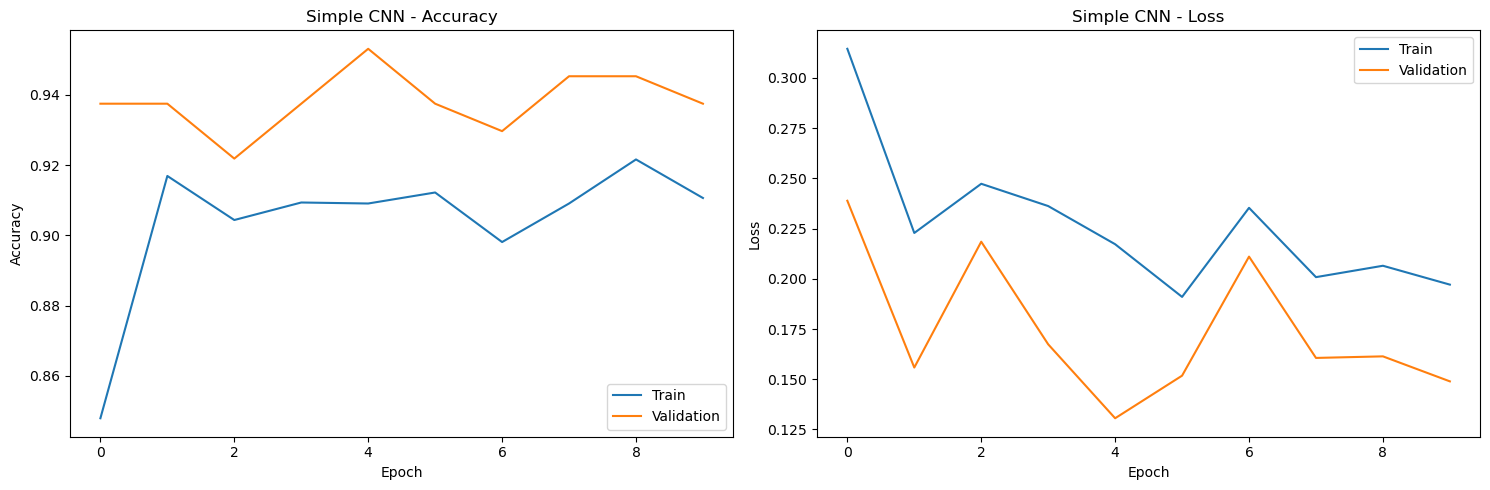

The Accuracy of the Neural Network on the Test Data is 0.9181818181818182


In [30]:
def plot_training_history(history, title):
    """Plot the training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_1, "Simple CNN")

predictions_nn_probs = cnn_model.predict(x_test)
predictions_nn = np.argmax(predictions_nn_probs, axis=1)
test_accuracy_nn = sklearn.metrics.accuracy_score(y_test, predictions_nn)

print("The Accuracy of the Neural Network on the Test Data is", test_accuracy_nn)

In [31]:
history_2 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 64,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 64,
)

Epoch 1/30
10/10 [==============================] - 21s 2s/step - loss: 0.2171 - accuracy: 0.9138 - val_loss: 0.1705 - val_accuracy: 0.9609
Epoch 2/30
10/10 [==============================] - 21s 2s/step - loss: 0.2294 - accuracy: 0.9154 - val_loss: 0.1439 - val_accuracy: 0.9453
Epoch 3/30
10/10 [==============================] - 20s 2s/step - loss: 0.2093 - accuracy: 0.9154 - val_loss: 0.1883 - val_accuracy: 0.9297
Epoch 4/30
10/10 [==============================] - 20s 2s/step - loss: 0.1935 - accuracy: 0.9185 - val_loss: 0.1961 - val_accuracy: 0.9219
Epoch 5/30
10/10 [==============================] - 21s 2s/step - loss: 0.1645 - accuracy: 0.9326 - val_loss: 0.1931 - val_accuracy: 0.9375
Epoch 6/30
10/10 [==============================] - 20s 2s/step - loss: 0.2052 - accuracy: 0.9154 - val_loss: 0.1622 - val_accuracy: 0.9453
Epoch 7/30
10/10 [==============================] - 21s 2s/step - loss: 0.2533 - accuracy: 0.9028 - val_loss: 0.2222 - val_accuracy: 0.9609
Epoch 8/30
10/10 [==

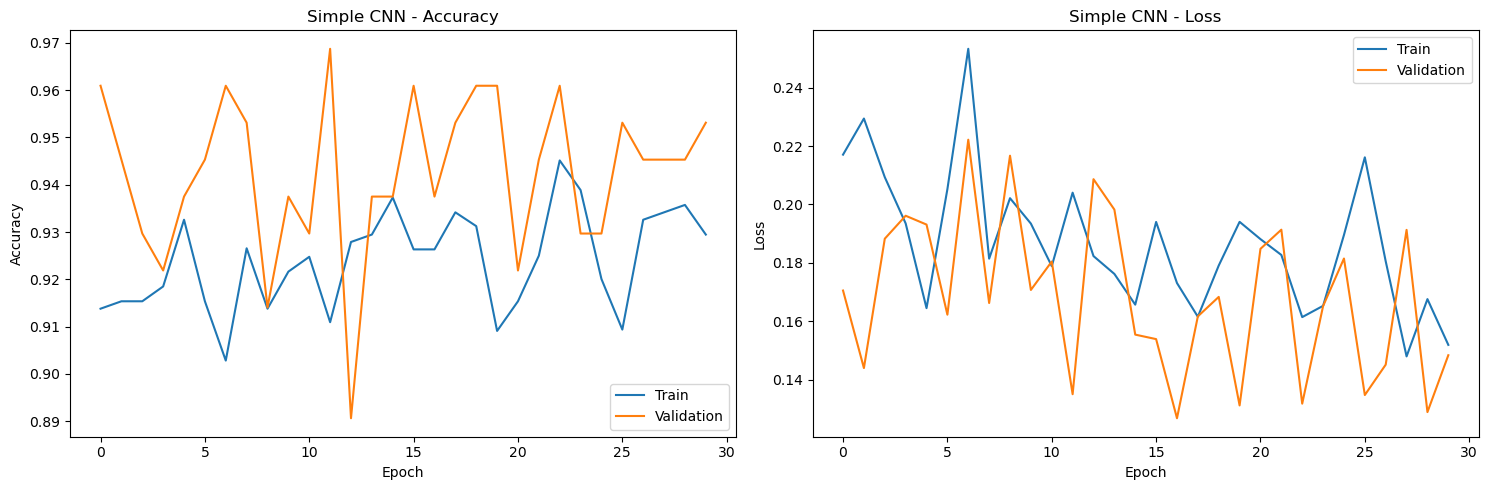

The Accuracy of the Neural Network on the Test Data is 0.9409090909090909


In [32]:
plot_training_history(history_2, "Simple CNN")

predictions_nn_probs_2 = cnn_model.predict(x_test)
predictions_nn_2 = np.argmax(predictions_nn_probs_2, axis=1)
test_accuracy_nn2 = sklearn.metrics.accuracy_score(y_test, predictions_nn_2)

print("The Accuracy of the Neural Network on the Test Data is", test_accuracy_nn2)

In [33]:
history_3 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 64,
    epochs= 50,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 64,
)

Epoch 1/50
10/10 [==============================] - 23s 2s/step - loss: 0.1661 - accuracy: 0.9248 - val_loss: 0.1433 - val_accuracy: 0.9531
Epoch 2/50
10/10 [==============================] - 21s 2s/step - loss: 0.1568 - accuracy: 0.9373 - val_loss: 0.1876 - val_accuracy: 0.9531
Epoch 3/50
10/10 [==============================] - 21s 2s/step - loss: 0.1515 - accuracy: 0.9357 - val_loss: 0.1042 - val_accuracy: 0.9688
Epoch 4/50
10/10 [==============================] - 21s 2s/step - loss: 0.1592 - accuracy: 0.9373 - val_loss: 0.1298 - val_accuracy: 0.9609
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 0.1525 - accuracy: 0.9373 - val_loss: 0.1544 - val_accuracy: 0.9453
Epoch 6/50
10/10 [==============================] - 21s 2s/step - loss: 0.1527 - accuracy: 0.9420 - val_loss: 0.1951 - val_accuracy: 0.9453
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 0.1605 - accuracy: 0.9326 - val_loss: 0.1533 - val_accuracy: 0.9766
Epoch 8/50
10/10 [==

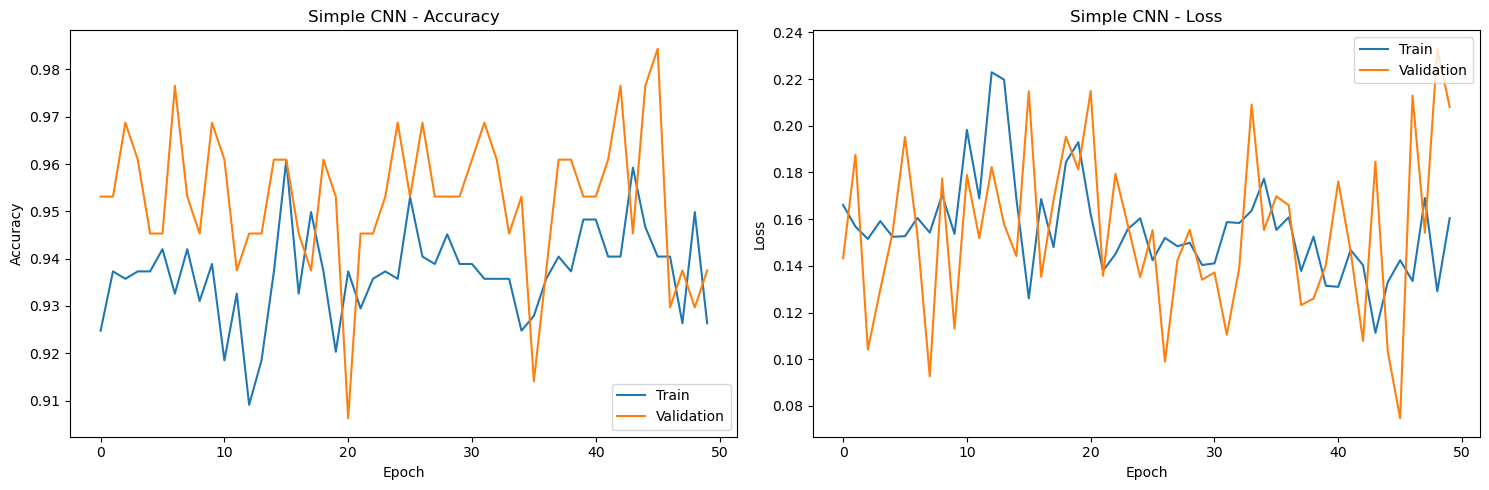

The Accuracy of the Neural Network on the Test Data is 0.95


In [34]:
plot_training_history(history_3, "Simple CNN")

predictions_nn_probs_3 = cnn_model.predict(x_test)
predictions_nn_3 = np.argmax(predictions_nn_probs_3, axis=1)
test_accuracy_nn3 = sklearn.metrics.accuracy_score(y_test, predictions_nn_3)

print("The Accuracy of the Neural Network on the Test Data is", test_accuracy_nn3)

The model was trained for 10, 30 and 50 epochs, and the results were evaluated using accuracy and loss plots for training and validation data. These key observations were made: 
**Training Duration:** Increasing epochs from 10 to 50 improved test accuracy from 0.918 to 0.95, with most gains occurring in early epochs.
**Performance Stability:** Shorter training (10 epochs) yielded remarkably stable learning curves, while longer training introduced significant    volatility without proportional accuracy gains.


